In [34]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [35]:
dataset_path = "glasses_noglasses_dataset"

img_size = (224, 224)  # EfficientNetB0 default size
batch_size = 32
seed = 42

full_dataset = image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=seed,
    validation_split=None
)

class_names = full_dataset.class_names
print("Class names:", class_names)

total_images = 0
for batch in full_dataset:
    total_images += batch[0].shape[0]

train_size = int(0.7 * total_images)
val_size = int(0.15 * total_images)
test_size = total_images - train_size - val_size

train_dataset = full_dataset.take(train_size // batch_size)
remaining = full_dataset.skip(train_size // batch_size)
val_dataset = remaining.take(val_size // batch_size)
test_dataset = remaining.skip(val_size // batch_size)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Found 2000 files belonging to 2 classes.
Class names: ['glasses', 'no_glasses']


In [36]:
def get_dataset_info(dataset, name):
    total = 0
    for images, labels in dataset:
        total += images.shape[0]
    print(f"{name} size: {total} samples")

get_dataset_info(train_dataset, "Train")
get_dataset_info(val_dataset, "Validation")
get_dataset_info(test_dataset, "Test")

Train size: 1376 samples
Validation size: 288 samples
Test size: 336 samples


In [37]:
import collections

def get_label_distribution(dataset, name):
    label_counts = collections.Counter()
    for _, labels in dataset:
        label_counts.update(labels.numpy().tolist())

    print(f"{name} label distribution:")
    for label, count in sorted(label_counts.items()):
        print(f"  {class_names[label]}: {count}")
    print()

get_label_distribution(train_dataset, "Train")
get_label_distribution(val_dataset, "Validation")
get_label_distribution(test_dataset, "Test")

Train label distribution:
  glasses: 707
  no_glasses: 669

Validation label distribution:
  glasses: 132
  no_glasses: 156

Test label distribution:
  glasses: 155
  no_glasses: 181



In [38]:
# Load base EfficientNetB0 model (without top layer)
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model for feature extraction

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [39]:
checkpoint_dir = "glasses_classification_saved_model"
os.makedirs(checkpoint_dir, exist_ok=True)

best_model_path = os.path.join(checkpoint_dir, "best_model.keras")
last_model_path = os.path.join(checkpoint_dir, "last_model.keras")

checkpoint_cb = ModelCheckpoint(
    best_model_path, monitor='val_accuracy', save_best_only=True, verbose=1, mode='max'
)

earlystop_cb = EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1
)

# feature extraction (first 10 epochs)
history_fe = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[checkpoint_cb, earlystop_cb]
)

# Save last model after feature extraction
model.save(last_model_path)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.4439 - loss: 0.7636
Epoch 1: val_accuracy improved from -inf to 0.50694, saving model to glasses_classification_saved_model\best_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 30s 484ms/step - accuracy: 0.4442 - loss: 0.7632 - val_accuracy: 0.5069 - val_loss: 0.7190
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.5159 - loss: 0.7082
Epoch 2: val_accuracy improved from 0.50694 to 0.60764, saving model to glasses_classification_saved_model\best_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 423ms/step - accuracy: 0.5161 - loss: 0.7079 - val_accuracy: 0.6076 - val_loss: 0.6682
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.6254 - loss: 0.6491
Epoch 3: val_accuracy improved from 0.60764 to 0.67014, saving model to glasses_classification_saved_model\best_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 435ms/step - accuracy: 0.6258 - loss: 0.6490 - val_accuracy: 0.6701 - val_loss: 0.6313
Epoch 4/10
43/43 ━━

In [40]:
# Unfreeze the base model
base_model.trainable = True

# Recompile with a low learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Show trainable layers for verification
print(f"Total layers: {len(model.layers)}")
print(f"Trainable layers: {len([l for l in model.layers if l.trainable])}")

Total layers: 241
Trainable layers: 241


In [41]:
# Paths to save updated model
finetune_best_path = os.path.join(checkpoint_dir, "best_model_finetuned.keras")
finetune_last_path = os.path.join(checkpoint_dir, "last_model_finetuned.keras")

# Callbacks
checkpoint_cb_finetune = ModelCheckpoint(
    finetune_best_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)

earlystop_cb_finetune = EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1
)

# Fine-tuning training
history_ft = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[checkpoint_cb_finetune, earlystop_cb_finetune]
)

# Save last model
model.save(finetune_last_path)

Epoch 1/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6727 - loss: 0.6075
Epoch 1: val_accuracy improved from -inf to 0.90278, saving model to glasses_classification_saved_model\best_model_finetuned.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.6742 - loss: 0.6063 - val_accuracy: 0.9028 - val_loss: 0.4273
Epoch 2/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9032 - loss: 0.4068
Epoch 2: val_accuracy improved from 0.90278 to 0.96875, saving model to glasses_classification_saved_model\best_model_finetuned.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9040 - loss: 0.4058 - val_accuracy: 0.9688 - val_loss: 0.3032
Epoch 3/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9768 - loss: 0.2654
Epoch 3: val_accuracy improved from 0.96875 to 0.98611, saving model to glasses_classification_saved_model\best_model_finetuned.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9768 - loss: 0.2650 - val_accuracy: 0.9861 - val_loss: 0.1407
Epoch 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Report:
              precision    recall  f1-score   support

     glasses       1.00      1.00      1.00       157
  no_glasses       1.00      1.00      1.00       179

    accuracy                           1.00       336
   macro avg       1.00      1.00      1.00       336
weighted avg       1.00      1.00      1.00       336



<Figure size 600x600 with 0 Axes>

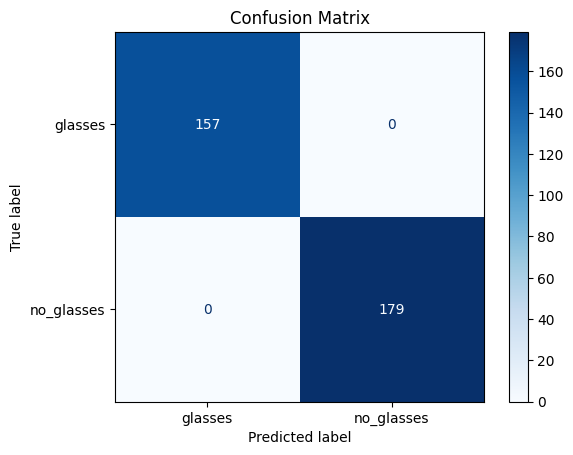

In [42]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Load the best saved model (optional, but safe)
model = tf.keras.models.load_model("glasses_classification_saved_model/best_model_finetuned.keras")

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype("int32").flatten()

    y_pred.extend(preds_binary)
    y_true.extend(labels.numpy())

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

🔢 Model Raw Output: 0.7712
🧠 Predicted Gender: no_glasses


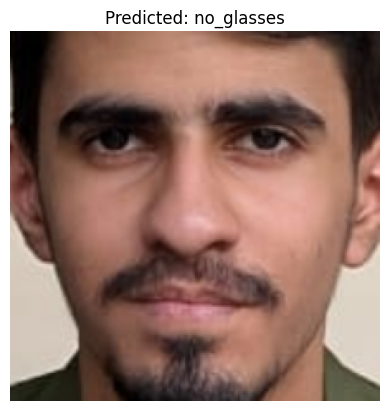

In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load your fine-tuned gender classification model
model = load_model("glasses_classification_saved_model/best_model_finetuned.keras")

# Class labels
class_names = ['glasses', 'no_glasses']

# Initialize MediaPipe face detector
mp_face_detection = mp.solutions.face_detection

def prediction_of_gender(image_path):
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detector:
        img = cv2.imread(image_path)

        if img is None:
            print("❌ Failed to read image.")
            return

        h, w, _ = img.shape
        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Detect face using MediaPipe
        results = face_detector.process(image_rgb)

        if not results.detections:
            print("😕 No face detected.")
            return

        # Get the first detected face
        bbox = results.detections[0].location_data.relative_bounding_box
        x = int(bbox.xmin * w)
        y = int(bbox.ymin * h)
        box_width = int(bbox.width * w)
        box_height = int(bbox.height * h)
        x, y = max(0, x), max(0, y)

        cropped_face = img[y:y + box_height, x:x + box_width]

        if cropped_face.size == 0:
            print("⚠️ Cropped face is empty.")
            return

        # Preprocess the face for prediction
        face_resized = cv2.resize(cropped_face, (224, 224))
        face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)
        img_array = img_to_array(face_rgb)
        img_array = np.expand_dims(img_array, axis=0)

        # Predict gender
        pred = model.predict(img_array)[0][0]
        gender = class_names[int(pred > 0.5)]

        print(f"\n🔢 Model Raw Output: {pred:.4f}")
        print(f"🧠 Predicted Gender: {gender}")

        # Show face with prediction
        plt.imshow(face_rgb)
        plt.title(f"Predicted: {gender}")
        plt.axis('off')
        plt.show()


# 🔍 Change the path to your test image here
image_path = "myimage2.jpg"
prediction_of_gender(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

🔢 Model Raw Output: 0.6066
🧠 Predicted Gender: no_glasses


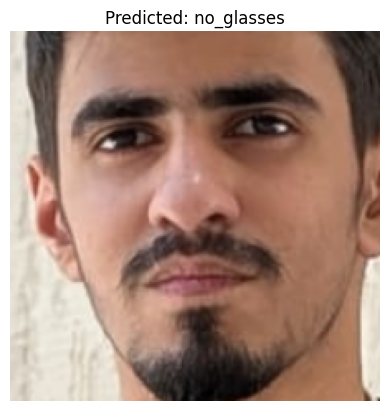

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load your fine-tuned gender classification model
model = load_model("glasses_classification_saved_model/best_model_finetuned.keras")

# Class labels
class_names = ['glasses', 'no_glasses']

# Initialize MediaPipe face detector
mp_face_detection = mp.solutions.face_detection

def prediction_of_gender(image_path):
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detector:
        img = cv2.imread(image_path)

        if img is None:
            print("❌ Failed to read image.")
            return

        h, w, _ = img.shape
        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Detect face using MediaPipe
        results = face_detector.process(image_rgb)

        if not results.detections:
            print("😕 No face detected.")
            return

        # Get the first detected face
        bbox = results.detections[0].location_data.relative_bounding_box
        x = int(bbox.xmin * w)
        y = int(bbox.ymin * h)
        box_width = int(bbox.width * w)
        box_height = int(bbox.height * h)
        x, y = max(0, x), max(0, y)

        cropped_face = img[y:y + box_height, x:x + box_width]

        if cropped_face.size == 0:
            print("⚠️ Cropped face is empty.")
            return

        # Preprocess the face for prediction
        face_resized = cv2.resize(cropped_face, (224, 224))
        face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)
        img_array = img_to_array(face_rgb)
        img_array = np.expand_dims(img_array, axis=0)

        # Predict gender
        pred = model.predict(img_array)[0][0]
        gender = class_names[int(pred > 0.5)]

        print(f"\n🔢 Model Raw Output: {pred:.4f}")
        print(f"🧠 Predicted Gender: {gender}")

        # Show face with prediction
        plt.imshow(face_rgb)
        plt.title(f"Predicted: {gender}")
        plt.axis('off')
        plt.show()


# 🔍 Change the path to your test image here
image_path = "myimage3.jpg"
prediction_of_gender(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

🔢 Model Raw Output: 0.7075
🧠 Predicted Gender: no_glasses


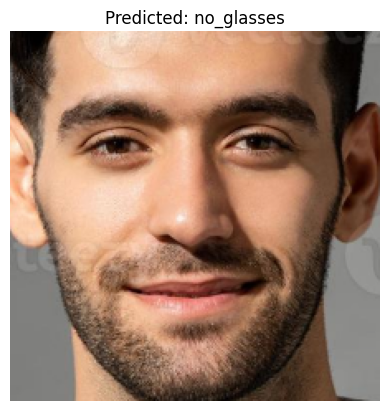

In [48]:


import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load your fine-tuned gender classification model
model = load_model("glasses_classification_saved_model/best_model_finetuned.keras")

# Class labels
class_names = ['glasses', 'no_glasses']

# Initialize MediaPipe face detector
mp_face_detection = mp.solutions.face_detection

def prediction_of_gender(image_path):
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detector:
        img = cv2.imread(image_path)

        if img is None:
            print("❌ Failed to read image.")
            return

        h, w, _ = img.shape
        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Detect face using MediaPipe
        results = face_detector.process(image_rgb)

        if not results.detections:
            print("😕 No face detected.")
            return

        # Get the first detected face
        bbox = results.detections[0].location_data.relative_bounding_box
        x = int(bbox.xmin * w)
        y = int(bbox.ymin * h)
        box_width = int(bbox.width * w)
        box_height = int(bbox.height * h)
        x, y = max(0, x), max(0, y)

        cropped_face = img[y:y + box_height, x:x + box_width]

        if cropped_face.size == 0:
            print("⚠️ Cropped face is empty.")
            return

        # Preprocess the face for prediction
        face_resized = cv2.resize(cropped_face, (224, 224))
        face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)
        img_array = img_to_array(face_rgb)
        img_array = np.expand_dims(img_array, axis=0)

        # Predict gender
        pred = model.predict(img_array)[0][0]
        gender = class_names[int(pred > 0.5)]

        print(f"\n🔢 Model Raw Output: {pred:.4f}")
        print(f"🧠 Predicted Gender: {gender}")

        # Show face with prediction
        plt.imshow(face_rgb)
        plt.title(f"Predicted: {gender}")
        plt.axis('off')
        plt.show()


# 🔍 Change the path to your test image here
image_path = "close-up-portrait-of-smiling-handsome-young-caucasian-man-face-looking-at-camera-on-isolated-light-gray-studio-background-photo.jpg"
prediction_of_gender(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

🔢 Model Raw Output: 0.4426
🧠 Predicted Gender: glasses


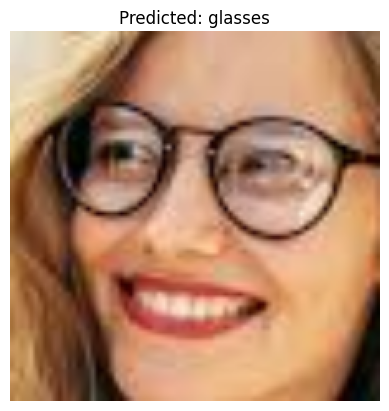

In [49]:


import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load your fine-tuned gender classification model
model = load_model("glasses_classification_saved_model/best_model_finetuned.keras")

# Class labels
class_names = ['glasses', 'no_glasses']

# Initialize MediaPipe face detector
mp_face_detection = mp.solutions.face_detection

def prediction_of_gender(image_path):
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detector:
        img = cv2.imread(image_path)

        if img is None:
            print("❌ Failed to read image.")
            return

        h, w, _ = img.shape
        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Detect face using MediaPipe
        results = face_detector.process(image_rgb)

        if not results.detections:
            print("😕 No face detected.")
            return

        # Get the first detected face
        bbox = results.detections[0].location_data.relative_bounding_box
        x = int(bbox.xmin * w)
        y = int(bbox.ymin * h)
        box_width = int(bbox.width * w)
        box_height = int(bbox.height * h)
        x, y = max(0, x), max(0, y)

        cropped_face = img[y:y + box_height, x:x + box_width]

        if cropped_face.size == 0:
            print("⚠️ Cropped face is empty.")
            return

        # Preprocess the face for prediction
        face_resized = cv2.resize(cropped_face, (224, 224))
        face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)
        img_array = img_to_array(face_rgb)
        img_array = np.expand_dims(img_array, axis=0)

        # Predict gender
        pred = model.predict(img_array)[0][0]
        gender = class_names[int(pred > 0.5)]

        print(f"\n🔢 Model Raw Output: {pred:.4f}")
        print(f"🧠 Predicted Gender: {gender}")

        # Show face with prediction
        plt.imshow(face_rgb)
        plt.title(f"Predicted: {gender}")
        plt.axis('off')
        plt.show()


# 🔍 Change the path to your test image here
image_path = "person_Wearing_glasses.jpeg"
prediction_of_gender(image_path)
